In [1]:
#this version of the program is using presets for the cyclic peptide library

In [2]:
#This program is used for unpaired read illumina sequencing fastq files.  The goal here is to take in your
#sequencing file, and to cut out reads that match your defined template.  In this case of a synthetic 
#peptide library we know the exact sequences that should be constant before and after our randomized positions.
#Using the user specified sequences we cut out those sequences and then translate them to AA sequences. 
# please note that the user specified sequences need to be in-frame (all of our mutants are in frame)

from Bio.Seq import Seq
from Bio import SeqIO
import modin.pandas as pd #multithreading version of pandas
from distributed import Client
client = Client()
def reverse_complement(seq):
    """Return the reverse complement of a DNA sequence"""
    return str(Seq(seq).reverse_complement())


# User-defined sequences in 5' to 3' direction - you can also add other startX and stopXs to the lists
seqs_5to3 = {
    "start1": "GAAGGGGTACAATTAGAT",
    "stop1": "GAATGGCATGAAGGT",
}

# User-defined sequences in 3' to 5' direction - this is the same sequence you put above, just in reverse
seqs_3to5 = {
    "start3": "ACCTTCATGCCATTC", #this should be the reverse complement of stop 1
    "stop3": "ATCTAATTGTACCCCTTC",#this should be the reverse complement of start1
}

# Convert 3' to 5' sequences to 5' to 3'
seqs_5to3.update(
    {f"{key}_rc": reverse_complement(val) for key, val in seqs_3to5.items()}
)

# Initialize an empty list to store results
results = []

# Iterate over each record in the FASTQ file
for record in SeqIO.parse("Illumina_test_peptide.fastq", "fastq"):
    # Extract the DNA sequence from the record
    seq = str(record.seq)

    # Iterate over the user-defined sequences
    for seq_key, seq_val in seqs_5to3.items():
        # Find the start and end indices of the sequence of interest
        start_index = seq.find(seq_val)
        end_index = seq.find(seqs_5to3[f"{seq_key.replace('start', 'stop')}"], start_index + len(seq_val))

        # Check if the sequence of interest was found
        if start_index != -1 and end_index != -1:
            # Extract the DNA sequence between the start and stop sequences
            dna_seq = seq[start_index + len(seq_val): end_index]

            # Reverse complement the DNA sequence if the user-defined sequence was in the 3' to 5' direction
            if seq_key.endswith("_rc"):
                dna_seq = reverse_complement(dna_seq)

            # Translate the DNA sequence to amino acids
            aa_seq = Seq(dna_seq).translate()

            # Add the result to the list of results
            results.append({"Sequence": aa_seq, "KD": "1"})

# Convert the results to a pandas DataFrame and write to an Excel file
df = pd.DataFrame(results)
df.to_excel("output-peptide.xlsx", index=False)

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


                                Sequence    KD
0  KREAEAGPHMADCAWHLGELVWCTGGGLNDIFEAQKI  0.50
1  KREAEAGPHMADCAWDLGELVWCTGGGLNDIFEAQKI  1.00
2  KREAEAGPHMADCAWDLGELVWCTGGGLNDIFEAQKI  1.00
3  KREAEAGPHMADCAWRLGELVWCTGGGLNDIFEAQKI  0.10
4  KREAEAGPHMADCAWKLGELVWCTGGGLNDIFEAQKI  0.01
5  KREAEAGPHMADCLYFLGELVWCTGGGLNDIFEAQKI  0.25
6  KREAEAGPHMADCLLFLGELVWCTGGGLNDIFEAQKI  0.35
Number of clusters found: 2


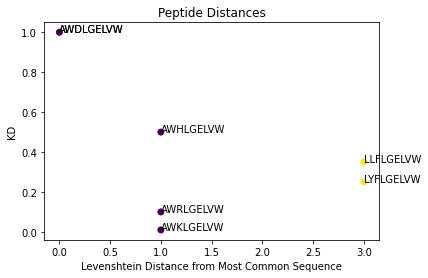

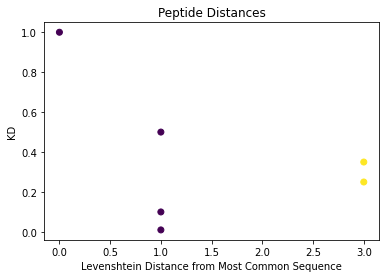

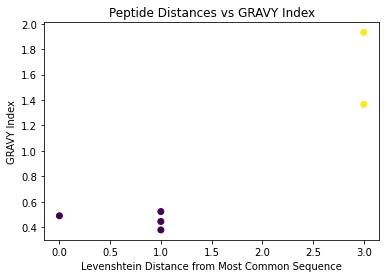

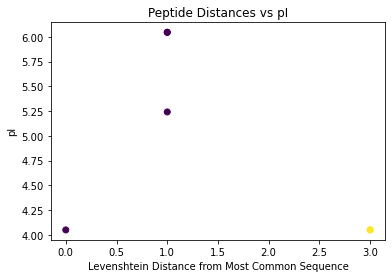

In [3]:
#this works, just has the future warning
import matplotlib.pyplot as plt
import pandas as pd
import Levenshtein as lev
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
from Levenshtein import distance
import numpy as np

# Define the framework sequences
frameworks = {
    'Framework1': 'KREAEAGPHMADC',
    'Framework2': 'CTGGGLNDIFEAQKI',
}

# Define the CDR loop positions relative to the framework sequences
cdr_positions = {
    'CDR1': ['Framework1', 'Framework2']
    #'CDR2': ['Framework2', 'Framework3'], #we don't need these because we only have one "framework"
    #'CDR3': ['Framework3', 'Framework4']
}

# Load the data from the Excel file
df = pd.read_excel('output-peptide-clusters.xlsx')
print(df)
# Extract the CDR loop sequences
cdr_seqs = {}
for cdr, positions in cdr_positions.items():
    start, end = positions
    cdr_seqs[cdr] = [seq[seq.find(frameworks[start])+len(frameworks[start]):seq.find(frameworks[end])] for seq in df['Sequence']]

# Calculate the frequency percentage of each CDR sequence as a percentage
cdr_freqs = {}
for cdr in cdr_seqs:
    cdr_count = len(cdr_seqs[cdr])
    cdr_freqs[cdr] = [cdr_seqs[cdr].count(seq)/cdr_count*100 for seq in cdr_seqs[cdr]]


# Find the most common CDR sequence for each loop
cdr_consensus_seqs = {}
for cdr in cdr_seqs:
    max_freq_idx = cdr_freqs[cdr].index(max(cdr_freqs[cdr]))
    cdr_consensus_seqs[cdr] = cdr_seqs[cdr][max_freq_idx]

# Calculate the Levenshtein distance between each CDR sequence and the consensus sequence
cdr_distances = {}
for cdr in cdr_seqs:
    cdr_distances[cdr] = [lev.distance(seq, cdr_consensus_seqs[cdr]) for seq in cdr_seqs[cdr]]

# Create a new dataframe with the results, removing duplicate sequences
cdr_df = pd.DataFrame()
for i, (sequence, kd) in df[['Sequence', 'KD']].iterrows():
    cdr_df = pd.concat([cdr_df, pd.DataFrame({'Sequence': sequence,
                                           'KD': kd,
                                           'CDR1 Seq': cdr_seqs['CDR1'][i],
                                           'CDR1 Freq': cdr_freqs['CDR1'][i],
                                           'CDR1 Distance': cdr_distances['CDR1'][i]}, index=[i])],
                    ignore_index=True)

cdr_df = cdr_df.drop_duplicates(subset=['Sequence', 'CDR1 Seq'])
cdr_df[['CDR1 Freq']] = cdr_df[['CDR1 Freq']].apply(lambda x: round(x, 2))


# Define a function to compute the pairwise distance matrix between all sequences
def pairwise_distance_matrix(sequences):
    n = len(sequences)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i, j] = distance(sequences[i], sequences[j])
            dist_matrix[j, i] = dist_matrix[i, j]
    return dist_matrix

# Compute the pairwise distance matrix
dist_matrix = pairwise_distance_matrix(cdr_df['CDR1 Seq'].values)

# Run DBSCAN on the distance matrix
dbscan = DBSCAN(metric='precomputed', eps=2, min_samples=2)
dbscan.fit(dist_matrix)

# Extract the cluster labels
cluster_labels = dbscan.labels_

# Print the number of clusters found
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Number of clusters found:', n_clusters)

# Add the cluster labels to the dataframe
cdr_df['Cluster'] = cluster_labels

from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd

# Define a function to calculate GRAVY and pI
def calculate_gravy_and_pi(seq):
    # Create a ProteinAnalysis object for the amino acid sequence
    protein = ProteinAnalysis(seq)
    
    # Calculate GRAVY
    gravy = protein.gravy()
    
    # Calculate pI
    pi = protein.isoelectric_point()
    
    return gravy, pi

# Apply the function to the 'CDR1 Seq' column and store the results in new columns
cdr_df[['GRAVY_Index', 'pI']] = pd.DataFrame(cdr_df['CDR1 Seq'].apply(calculate_gravy_and_pi).tolist(), index=cdr_df.index)
cdr_df = cdr_df.reset_index(drop=True)
# Save the results to a new Excel file
cdr_df.to_excel('peptide_distances.xlsx', index=False)

# Create scatterplots for each CDR loop

for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['KD'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence')
    plt.ylabel('KD')
    plt.title("Peptide Distances")
    for i, seq in enumerate(cdr_seqs[cdr]):
        plt.annotate(seq, (cdr_distances[cdr][i], df['KD'][i]))
    plt.savefig('Scatter_with_sequences.png', dpi=300)
    plt.show()
    
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['KD'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence')
    plt.ylabel('KD')
    plt.title("Peptide Distances")
    plt.savefig('Scatter_only_KD_distance.png', dpi=300)
    plt.show()
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['GRAVY_Index'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence')
    plt.ylabel('GRAVY Index')
    plt.title("Peptide Distances vs GRAVY Index")
    plt.savefig('Scatter_only_GRAVY_distance.png', dpi=300)
    plt.show()
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['pI'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence')
    plt.ylabel('pI')
    plt.title("Peptide Distances vs pI")
    plt.savefig('Scatter_only_pI_distance.png', dpi=300)
    plt.show()

In [4]:
cdr_df


,Sequence,KD,CDR1 Seq,CDR1 Freq,CDR1 Distance,Cluster,GRAVY_Index,pI
0,KREAEAGPHMADCAWHLGELVWCTGGGLNDIFEAQKI,0.50,AWHLGELVW,14.29,1,0,0.522222,5.241828
1,KREAEAGPHMADCAWDLGELVWCTGGGLNDIFEAQKI,1.00,AWDLGELVW,28.57,0,0,0.488889,4.050028
2,KREAEAGPHMADCAWRLGELVWCTGGGLNDIFEAQKI,0.10,AWRLGELVW,14.29,1,0,0.377778,6.047009
3,KREAEAGPHMADCAWKLGELVWCTGGGLNDIFEAQKI,0.01,AWKLGELVW,14.29,1,0,0.444444,6.046100
4,KREAEAGPHMADCLYFLGELVWCTGGGLNDIFEAQKI,0.25,LYFLGELVW,14.29,3,1,1.366667,4.050028
5,KREAEAGPHMADCLLFLGELVWCTGGGLNDIFEAQKI,0.35,LLFLGELVW,14.29,3,1,1.933333,4.050028


In [5]:
import plotly.graph_objects as go
import modin.pandas as pd
from IPython.display import display, HTML
from ipywidgets import widgets
import io
import base64

# Define the amino acids and their numerical values
amino_acids = [("R",0),("H",1),("K",2),("D",3),("E",4),("S",5),("T",6),("N",7),("Q",8),("C",9),("G",10),("P",11),("A",12),("V",13),("I",14),("L",15),("M",16),("F",17),("Y",18),("W",19),("Del",20)]
aa_dict = {aa: num for aa, num in amino_acids}

# Read in the data from the CSV file
df = pd.read_csv("CDR_Parallel.csv")

# Replace the amino acid values with their numerical equivalents
for col in df.columns:
    if col.startswith("CDR"):
        df[col] = df[col].apply(lambda x: aa_dict[x])

# Define the tick values and tick text for the plot
tick_values = list(range(len(amino_acids)))
tick_text = [aa[0] for aa in amino_acids]

# Create a list of dictionaries to define the dimensions for the plot
dimensions = []
for col in df.columns:
    if col.startswith("CDR"):
        dimensions.append(dict(range=[0,21], tickvals=tick_values, ticktext=tick_text, label=col, values=df[col]))

# Create the parallel coordinates plot with custom height and width
fig = go.FigureWidget(data=
    go.Parcoords(
        line=dict(colorscale='Electric', showscale=True, cmin=-4000, cmax=-100),
        dimensions=dimensions
    ),
    layout=dict(height=1800, width=2500)
)

# Define the function to update the table based on the selected lines
def update_table(trace, points, state):
    selected_df = pd.DataFrame(points.point_data.data)
    table = selected_df.drop(columns=["dimension", "trace"])
    table.columns = [c.replace("_", " ") for c in table.columns]
    #table_widget.clear_output()
    with table_widget:
        display(table)

# Add the brushing callback to the figure
fig.data[0].on_selection(update_table)
#Add brushing to table


# Add a table of the data
table = df.copy()
table.columns = [c.replace("_", " ") for c in table.columns]
table_widget = widgets.Output()
with table_widget:
    display(table)

# Add the table and export button to the figure
fig.add_trace(go.Table(
    header=dict(values=list(table.columns), align='left'),
    cells=dict(values=[table[c] for c in table.columns], align='left')
))

button = widgets.Button(description="Export to Excel")
output = widgets.Output()

def on_button_click(b):
    # Save the table to Excel and display a success message
    with io.BytesIO() as buffer:
        writer = pd.ExcelWriter(buffer, engine='xlsxwriter')
        table.to_excel(writer)
        writer.save()
        buffer.seek(0)
        data = buffer.read()
        b64 = base64.b64encode(data).decode()
        href = f'<a href="data:application/vnd.openxmlformats-officedocument.spreadsheetml.sheet;base64,{b64}" download="CDR_Parallel_values.xlsx">Download Excel file</a>'
        with output:
            print("Export successful!")
            display(HTML(href)) 
button.on_click(on_button_click)

#Create a VBox container to hold the figure, table, and export button widgets
#widgets.VBox([fig, table_widget, widgets.HBox([button, output])])


In [6]:
cdr_df

,Sequence,KD,CDR1 Seq,CDR1 Freq,CDR1 Distance,Cluster,GRAVY_Index,pI
0,KREAEAGPHMADCAWHLGELVWCTGGGLNDIFEAQKI,0.50,AWHLGELVW,14.29,1,0,0.522222,5.241828
1,KREAEAGPHMADCAWDLGELVWCTGGGLNDIFEAQKI,1.00,AWDLGELVW,28.57,0,0,0.488889,4.050028
2,KREAEAGPHMADCAWRLGELVWCTGGGLNDIFEAQKI,0.10,AWRLGELVW,14.29,1,0,0.377778,6.047009
3,KREAEAGPHMADCAWKLGELVWCTGGGLNDIFEAQKI,0.01,AWKLGELVW,14.29,1,0,0.444444,6.046100
4,KREAEAGPHMADCLYFLGELVWCTGGGLNDIFEAQKI,0.25,LYFLGELVW,14.29,3,1,1.366667,4.050028
5,KREAEAGPHMADCLLFLGELVWCTGGGLNDIFEAQKI,0.35,LLFLGELVW,14.29,3,1,1.933333,4.050028


In [15]:
from Bio import pairwise2
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
cdr_seqs = {'CDR1': ['AWHLGELVW','AWDLGELVW', 'AWHLGELVW']}
seq_records = [SeqRecord(Seq(seq), id='seq{}'.format(i+1)) for i, seq in enumerate(cdr_seqs)]
seq_records = [SeqRecord(Seq(seq.strip()), id='seq{}'.format(i+1)) for i, seq in enumerate(cdr_seqs)]

print(seq_records)
# Check that all CDR1 sequences have the same length
# Perform pairwise alignment using Needleman-Wunsch algorithm
alignments = pairwise2.align.globalxx(seq_records[0].seq, seq_records[1].seq)
seq1_aligned, seq2_aligned, score, begin, end = alignments[0]
aligned_records = [seq_records[0], seq_records[1]]
aligned_records[0].seq = Seq(seq1_aligned)
aligned_records[1].seq = Seq(seq2_aligned)

for i in range(2, len(seq_records)):
    alignments = pairwise2.align.globalxx(aligned_records[0].seq, seq_records[i].seq)
    seq_aligned, aligned_seq, score, begin, end = alignments[0]
    aligned_seq_record = SeqRecord(Seq(aligned_seq), id='seq{}'.format(i+1))
    aligned_seq_record = aligned_seq.lstrip('-')
    aligned_records.append(aligned_seq_record)

alignment = MultipleSeqAlignment(aligned_records)

# Write aligned sequences to a file in FASTA format
with open('alignment.fa', 'w') as f:
    AlignIO.write(alignment, f, 'fasta')


[SeqRecord(seq=Seq('CDR1'), id='seq1', name='<unknown name>', description='<unknown description>', dbxrefs=[])]


IndexError: list index out of range

In [ ]:
import logomaker
from Bio import AlignIO

# Read in the alignment file in FASTA format
alignment = AlignIO.read("alignment.fa", "fasta")

# Convert the alignment to a list of sequences
sequences = [str(record.seq) for record in alignment]

# Convert the sequences to a pandas dataframe
alignment_df = logomaker.alignment_to_matrix(sequences)

# Create the sequence logo
logo = logomaker.Logo(alignment_df, color_scheme='dmslogo_funcgroup')
# Customize the logo appearance
logo.style_spines(visible=False)
logo.ax.xaxis.set_tick_params(labelsize=8, which='major', pad=0)
logo.ax.xaxis.set_tick_params(labelsize=0, which='minor', pad=0)
logo.ax.xaxis.set_major_locator(plt.MultipleLocator(1))

# Save the figure as a PDF file
logo_fig = logo.fig
logo_fig.savefig('peptide_logo.png', dpi=300)


In [13]:
print(seq_records)

[SeqRecord(seq=Seq('AWHLGELVW'), id='seq1', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('AWDLGELVW'), id='seq2', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('AWRLGELVW'), id='seq3', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('AWKLGELVW'), id='seq4', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('LYFLGELVW'), id='seq5', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('LLFLGELVW'), id='seq6', name='<unknown name>', description='<unknown description>', dbxrefs=[])]


In [18]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO
import pandas as pd

# Read the amino acid sequences from the CDR1 Seq column of the dataframe
sequences = [SeqRecord(Seq(seq), id=str(i+1)) for i, seq in enumerate(cdr_df['CDR1 Seq'])]

# Align the sequences
alignment = MultipleSeqAlignment(sequences)

# Write the aligned sequences to a file in FASTA format
with open('cdr1_global_alignment.fa', 'w') as f:
    AlignIO.write(alignment, f, 'fasta')
print("Global alignment completed")

In [20]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Read the sequences from the DataFrame
cdr_sequences = cdr_df['CDR1 Seq'].tolist()

# Group sequences by cluster
groups = cdr_df.groupby('Cluster')
for cluster, group in groups:
    # Create a list of SeqRecord objects
    seq_records = []
    for i, seq in enumerate(group['CDR1 Seq']):
        seq_record = SeqRecord(Seq(seq), id=f'seq{i+1}')
        seq_records.append(seq_record)
    
    # Align the sequences
    alignment = MultipleSeqAlignment(seq_records)
    
    # Write the aligned sequences to a file in FASTA format
    with open(f'cdr1_alignment_{cluster}.fa', 'w') as f:
        SeqIO.write(alignment, f, 'fasta')
print("Cluster alignments completed")